In [925]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [926]:
DATA_PATH = 'dsp_data/'
for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

2024_gt.csv
2024_test.csv
2024_test_R2.csv
2024_test_r3.csv
2024_test_r4.csv
2024_test_r5.csv
2024_test_r6.csv
2024_tourney_seeds.csv
Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thruSeason2024_day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
sample_submission.csv


## **Data Loading**

In [927]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")

df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [928]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [929]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [930]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


## **Features:**

**Compute:**

Number of Wins and Losses

Avg Score Gap in Wins and Losses

Points scored in Wins and Losses

Field Goal Percentage

Number of Two-pointers and three-pointers made

Number of free throws attempted and made

Number of offensive and defensive rebounds

Turnovers and Assists per game


**To Derive the Following Features:**

Assists per game

Blocks per game

Field Goal Percentage

Points per game

Rebounds per game

Effective Field Goal Percentage

True Shooting Percentage

Margin of Victory

Pythagorean Wins/Losses

Assist/Turnover Ratio

In [931]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [932]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [933]:
pts_win = df_season_results.groupby(['Season', 'WTeamID']).sum()
pts_win = pts_win.reset_index()[['Season', 'WTeamID', "WScore", "LScore"]].rename(columns={"WScore": "WTotalPoints", "WTeamID": "TeamID", "LScore": "LPointsAgainst"})

In [934]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [935]:
pts_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
pts_loss = pts_loss.reset_index()[['Season', 'LTeamID', 'LScore', "WScore"]].rename(columns={"LScore": "LTotalPoints", "LTeamID": "TeamID", "WScore": "WPointsAgainst"})

In [936]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [937]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [938]:
df_wefg = df_season_results.groupby(['Season', 'WTeamID']).sum()
df_wefg = df_wefg.reset_index()[['Season', 'WTeamID', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3']].rename(columns={"WTeamID": "TeamID"})

In [939]:
df_lefg = df_season_results.groupby(['Season', 'LTeamID']).sum()
df_lefg = df_lefg.reset_index()[['Season', 'LTeamID', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3']].rename(columns={"LTeamID": "TeamID"})

In [940]:
wts = df_season_results.groupby(['Season', 'WTeamID']).sum()
wts = wts.reset_index()[['Season', 'WTeamID', 'WScore', 'WFTA']].rename(columns={"WTeamID":"TeamID"})

In [941]:
lts = df_season_results.groupby(['Season', 'LTeamID']).sum()
lts = lts.reset_index()[['Season', 'LTeamID', 'LScore', 'LFTA']].rename(columns={"LTeamID": "TeamID"})

In [942]:
watv = df_season_results.groupby(['Season', 'WTeamID']).sum()
watv = watv.reset_index()[['Season', 'WTeamID', 'WAst', 'WTO']].rename(columns={"WTeamID": "TeamID"})

In [943]:
latv = df_season_results.groupby(['Season', 'LTeamID']).sum()
latv = latv.reset_index()[['Season', 'LTeamID', 'LAst', 'LTO']].rename(columns={"LTeamID": "TeamID"})

In [944]:
wrb = df_season_results.groupby(['Season', 'WTeamID']).sum()
wrb = wrb.reset_index()[['Season', 'WTeamID', 'WOR']].rename(columns={"WTeamID":"TeamID"})

In [945]:
lrb = df_season_results.groupby(['Season', 'LTeamID']).sum()
lrb = lrb.reset_index()[['Season', 'LTeamID', 'LOR']].rename(columns={"LTeamID":"TeamID"})

In [946]:
wagainst = df_season_results.groupby(['Season', 'WTeamID']).sum()
wagainst = wagainst.reset_index()[['Season', 'WTeamID', 'LFGA', 'LFTA', 'LOR', 'LTO']].rename(columns={"WTeamID":"TeamID", "LFGA":"WFGAopp", "LFTA":"WFTAopp", "LOR":"WORopp", "LTO":"WTOopp"})

In [947]:
lagainst = df_season_results.groupby(['Season', 'LTeamID']).sum()
lagainst = lagainst.reset_index()[['Season', 'LTeamID', 'WFGA', 'WFTA', 'WOR', 'WTO']].rename(columns={'LTeamID':"TeamID", 'WFGA':'LFGAopp', 'WFTA': 'LFTAopp', 'WOR': 'LORopp', 'WTO':'LTOopp'})

In [948]:
wdrb = df_season_results.groupby(['Season', 'WTeamID']).sum()
wdrb = wdrb.reset_index()[['Season', 'WTeamID', 'WDR']].rename(columns={"WTeamID":"TeamID"})

In [949]:
ldrb = df_season_results.groupby(['Season', 'LTeamID']).sum()
ldrb = ldrb.reset_index()[['Season', 'LTeamID', 'LDR']].rename(columns={"LTeamID":"TeamID"})

In [950]:
wbl = df_season_results.groupby(['Season', 'WTeamID']).sum()
wbl = wbl.reset_index()[['Season', 'WTeamID', 'WBlk']].rename(columns={"WTeamID":"TeamID"})

In [951]:
lbl = df_season_results.groupby(['Season', 'LTeamID']).sum()
lbl = lbl.reset_index()[['Season', 'LTeamID', 'LBlk']].rename(columns={"LTeamID":"TeamID"})

In [952]:
wstl = df_season_results.groupby(['Season', 'WTeamID']).sum()
wstl = wstl.reset_index()[['Season', 'WTeamID', 'WStl']].rename(columns={"WTeamID":"TeamID"})

In [953]:
lstl = df_season_results.groupby(['Season', 'LTeamID']).sum()
lstl = lstl.reset_index()[['Season', 'LTeamID', 'LStl']].rename(columns={"LTeamID":"TeamID"})

In [954]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [955]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [956]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(pts_win, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(pts_loss, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(df_wefg, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(df_lefg, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wts, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lts, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(watv, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(latv, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wagainst, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lagainst, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wbl, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lbl, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wdrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(ldrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wstl, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lstl, on=["Season", 'TeamID'], how="left")

In [957]:
df_features_season.fillna(0, inplace=True)

In [958]:
df_features_season['BPG'] = (df_features_season['WBlk'] + df_features_season['LBlk']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [959]:
df_features_season['SPG'] = (df_features_season['WStl'] + df_features_season['LStl']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [960]:
df_features_season['RPG'] = (df_features_season['WOR'] + df_features_season['LOR']+ df_features_season['LDR'] + df_features_season['WDR']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [961]:
df_features_season['PPG'] = (df_features_season['WScore'] + df_features_season['LScore']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [962]:
df_features_season['APG'] = (df_features_season['WAst'] + df_features_season['LAst']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [963]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] -
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [964]:
df_features_season.drop(['WBlk', 'LBlk'], axis=1, inplace=True)

In [965]:
df_features_season.drop(['WStl', 'LStl'], axis=1, inplace=True)

In [966]:
df_features_season.drop(['WDR', 'LDR'], axis=1, inplace=True)

In [967]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [968]:
df_features_season['PointsFor'] = df_features_season['WTotalPoints'] + df_features_season['LTotalPoints']
df_features_season['PointsAgainst'] = df_features_season['LPointsAgainst'] + df_features_season["WPointsAgainst"]

In [969]:
df_features_season.drop(['WTotalPoints', 'LTotalPoints', 'LPointsAgainst', 'WPointsAgainst'], axis=1, inplace=True)

In [970]:
# https://captaincalculator.com/sports/basketball/pythagorean-win-percentage-calculator/
# Pythagorean win pct
# Using the Daryl Morey exponent
exp = 13.91
df_features_season["PyWinPct"] = df_features_season['PointsFor']**exp / ((df_features_season['PointsFor']**exp)+(df_features_season['PointsAgainst']**exp))

In [971]:
# Effective Field Goal Percentage
# https://www.breakthroughbasketball.com/stats/effective-field-goal-percentage.html

df_features_season['2PFGM'] = df_features_season['WFGM'] + df_features_season['LFGM'] - df_features_season['WFGM3'] -df_features_season['LFGM3']
df_features_season["FGA"] = df_features_season['WFGA'] + df_features_season['LFGA']
df_features_season['3PFGM'] = df_features_season['WFGA3'] + df_features_season['WFGA3']

df_features_season["EFG"] = (df_features_season["2PFGM"] + 1.5 * df_features_season["3PFGM"]) / df_features_season["FGA"]
df_features_season['FGPct'] = (df_features_season["2PFGM"] + df_features_season["3PFGM"]) / (df_features_season["FGA"])
df_features_season.drop(['2PFGM', '3PFGM'], axis=1, inplace=True)

In [972]:
# True Shooting Percentage
# https://www.breakthroughbasketball.com/stats/tsp_calc.html
df_features_season["TS"] = (
    (df_features_season['WScore'] + df_features_season['LScore']) /
    (2 *
    (df_features_season['FGA'] + 0.44 * (df_features_season['LFTA'] + df_features_season['WFTA'])))
)

In [973]:
# Assist Turnover Ratio
# https://captaincalculator.com/sports/basketball/assist-turnover-ratio-calculator/
df_features_season["ATR"] = (df_features_season['WAst']+df_features_season['LAst'])/(df_features_season['LTO']+df_features_season['WTO'])

In [974]:
# Defensive Rating
# https://www.fromtherumbleseat.com/pages/advanced-basketball-statistics-formula-sheet
df_features_season["ORB"] = df_features_season['WOR'] + df_features_season['LOR']
df_features_season['TOV'] = df_features_season['WTO'] + df_features_season['LTO']
df_features_season["TmPos"] = 0.5 * (df_features_season['FGA'] + 0.475 * (df_features_season['LFTA'] + df_features_season['WFTA']) - df_features_season['ORB'] + df_features_season['TOV'])


In [975]:
df_features_season["ORBopp"] = df_features_season['WORopp'] + df_features_season['LORopp']
df_features_season['TOVopp'] = df_features_season['WTOopp'] + df_features_season['LTOopp']
df_features_season["FGAopp"] = df_features_season['LFGAopp'] + df_features_season['WFGAopp']
df_features_season['FTAopp'] = df_features_season['LFTAopp'] + df_features_season['WFTAopp']
df_features_season['OppPos'] = 0.5*(df_features_season['FGAopp']+ (0.475*df_features_season['FTAopp']) - df_features_season['ORBopp'] + df_features_season['TOVopp'])

In [976]:
df_features_season["DRTG"] =  (100/(df_features_season["TmPos"]+df_features_season["OppPos"]))*df_features_season["PointsAgainst"]

In [977]:
df_features_season.drop(['WOR', 'LOR', 'ORB', 'TOV', 'TmPos', 'OppPos', 'ORBopp', 'TOVopp', 'FGAopp', 'FTAopp'], axis =1, inplace=True)

In [978]:
df_features_season.drop(['WORopp', 'LORopp', 'WTOopp', 'LTOopp', 'LFGAopp', 'WFGAopp', 'WFTAopp', 'LFTAopp'], axis=1, inplace=True)

In [979]:
df_features_season.drop(['PointsFor', 'PointsAgainst'], axis=1, inplace=True)

In [980]:
df_features_season.drop(['WFGM', 'WFGA', "WFGM3", "WFGA3", 'LFGM', 'LFGA', "LFGM3", "LFGA3", "FGA", "WScore", "LScore", "LFTA", "WFGA", "WFTA", 'WAst', 'LAst', 'WTO', 'LTO'], axis=1, inplace=True)

In [981]:
# Filter to include years 2016 and beyond
df_features_season = df_features_season[df_features_season['Season'] >= 2016]

In [982]:
df_seeds = df_seeds[df_seeds["Season"] >= 2016]
df_seeds["Seed"] = df_seeds["Seed"].apply(lambda x: int(re.sub(r"\D", "", x)))
df_seeds.head()

,Season,Seed,TeamID
2014,2016,1,1314
2015,2016,2,1462
2016,2016,3,1452
2017,2016,4,1246
2018,2016,5,1231


In [983]:
# add seed to teamid and season
df_features_season = df_seeds.merge(df_features_season, on=["Season", "TeamID"], how="left")

In [984]:
df_features_season.head()

,Season,Seed,TeamID,BPG,SPG,RPG,PPG,APG,WinRatio,GapAvg,PyWinPct,EFG,FGPct,TS,ATR,DRTG
0,2016,1,1314,4.382353,6.882353,40.970588,82.264706,18.117647,0.823529,12.705882,0.950899,1.064472,0.841335,0.560027,1.660377,79.506412
1,2016,2,1462,3.062500,7.312500,41.000000,81.343750,16.375000,0.843750,10.312500,0.936886,1.173375,0.891125,0.564868,1.284314,79.623559
2,2016,3,1452,2.529412,9.941176,39.176471,79.205882,14.764706,0.764706,12.588235,0.976096,1.057073,0.821951,0.546070,1.054622,69.010349
3,2016,4,1246,5.647059,5.617647,38.588235,79.676471,14.411765,0.764706,11.411765,0.965513,1.054214,0.823558,0.571307,1.310160,71.762854
4,2016,5,1231,3.968750,6.937500,37.375000,82.281250,15.968750,0.781250,13.375000,0.972797,1.306867,0.981760,0.615981,1.169336,74.844169


In [985]:
tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
tourney_results.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_results = tourney_results[tourney_results['Season'] >= 2016]
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
1983,2016,134,1195,96,1192,65
1984,2016,134,1455,70,1435,50
1985,2016,135,1221,59,1380,55
1986,2016,135,1276,67,1409,62
1987,2016,136,1114,85,1345,83


In [986]:
tourney_results.drop(['DayNum','WScore','LScore'], axis=1,inplace=True)
print(tourney_results.shape)

(468, 3)


In [987]:
df_test = tourney_results
df_test['Pred'] = 0.5
# increment ID for df_test column
df_test['ID'] = df_test.index
df_test

,Season,WTeamID,LTeamID,Pred,ID
1983,2016,1195,1192,0.5,1983
1984,2016,1455,1435,0.5,1984
1985,2016,1221,1380,0.5,1985
1986,2016,1276,1409,0.5,1986
1987,2016,1114,1345,0.5,1987
...,...,...,...,...,...
2446,2023,1274,1400,0.5,2446
2447,2023,1361,1166,0.5,2447
2448,2023,1163,1274,0.5,2448
2449,2023,1361,1194,0.5,2449


In [988]:
# merge features for winning team, returns NaN for every entry, not working correctly
df_test = df_test.merge(df_features_season, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"], how="left")
# rename columns to W prefix
df_test.rename(columns={"Seed": "WSeed","WinRatio":"WWinRatio", "PyWinPct":"WPyWinPct", "GapAvg":"WGapAvg", "EFG":"WEFG", "TS":"WTS", "ATR":"WATR", "DRTG":"WDRTG", "BPG": "WBPG", "APG" : "WAPG", "PPG" : "WPPG", "RPG" : "WRPG", "SPG" : "WSPG", "FGPct" : "WFGPct"}, inplace=True)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)

# merge features for losing team, returns NaN for every entry, not working correctly
df_test = df_test.merge(df_features_season, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"], how="left")
# rename columns to L prefix
df_test.rename(columns={"Seed": "LSeed","WinRatio":"LWinRatio", "PyWinPct":"LPyWinPct", "GapAvg":"LGapAvg", "EFG":"LEFG", "TS":"LTS", "ATR":"LATR", "DRTG":"LDRTG", "BPG": "LBPG", "APG" : "LAPG", "PPG" : "LPPG", "RPG" : "LRPG", "SPG" : "LSPG", "FGPct" : "LFGPct"}, inplace=True)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)
df_test

,Season,WTeamID,LTeamID,Pred,ID,WSeed,WBPG,WSPG,WRPG,WPPG,WAPG,WWinRatio,WGapAvg,WPyWinPct,WEFG,WFGPct,WTS,WATR,WDRTG,LSeed,LBPG,LSPG,LRPG,LPPG,LAPG,LWinRatio,LGapAvg,LPyWinPct,LEFG,LFGPct,LTS,LATR,LDRTG
0,2016,1195,1192,0.5,1983,16,4.034483,6.137931,39.413793,75.586207,12.896552,0.551724,2.724138,0.897271,0.786452,0.652698,0.542317,1.074713,54.299848,16,2.516129,7.354839,33.129032,76.838710,14.096774,0.548387,-1.677419,0.799285,0.903191,0.714362,0.551992,1.084367,56.926712
1,2016,1455,1435,0.5,1984,11,3.580645,7.258065,37.483871,73.129032,14.322581,0.741935,13.709677,0.987536,1.095265,0.832312,0.541371,1.455738,63.152546,11,5.531250,4.312500,38.562500,76.750000,14.937500,0.593750,9.406250,0.982146,0.987952,0.762870,0.572964,1.278075,53.269416
2,2016,1221,1380,0.5,1985,16,2.515152,6.454545,30.121212,65.333333,13.909091,0.424242,-4.333333,0.841737,0.778151,0.612325,0.521186,1.267956,41.061483,16,3.322581,7.354839,35.419355,71.225806,10.322581,0.612903,1.870968,0.885170,0.877585,0.696478,0.527352,0.911681,57.246659
3,2016,1276,1409,0.5,1986,11,2.090909,5.424242,32.030303,74.424242,14.969697,0.636364,6.242424,0.969639,1.115261,0.841515,0.582399,1.538941,59.721301,11,2.677419,6.806452,35.032258,74.000000,13.709677,0.645161,4.322581,0.911156,1.014501,0.784161,0.543994,1.268657,60.318748
4,2016,1114,1345,0.5,1987,12,3.064516,6.290323,32.903226,70.000000,12.903226,0.870968,9.935484,0.935576,1.213192,0.916372,0.561699,1.261830,78.757438,5,4.647059,4.264706,40.823529,77.735294,17.588235,0.764706,13.147059,0.978401,1.159091,0.886364,0.578135,1.472906,69.765184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.781250,7.281250,0.880799,1.161950,0.894130,0.588282,1.365714,78.140444,2,3.647059,8.058824,31.735294,77.852941,15.911765,0.764706,10.441176,0.961773,1.130010,0.869990,0.567967,1.442667,66.380356
464,2023,1361,1166,0.5,2447,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.812500,7.531250,0.912279,1.172622,0.888950,0.545244,1.194842,73.963932,6,4.181818,5.242424,34.757576,76.636364,15.909091,0.636364,8.151515,0.963907,1.104992,0.841997,0.579185,1.450276,57.842525
465,2023,1163,1274,0.5,2448,4,4.878788,6.545455,35.939394,78.454545,17.272727,0.757576,13.424242,0.978436,1.251893,0.937910,0.574027,1.400491,67.540952,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.781250,7.281250,0.880799,1.161950,0.894130,0.588282,1.365714,78.140444
466,2023,1361,1194,0.5,2449,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.812500,7.531250,0.912279,1.172622,0.888950,0.545244,1.194842,73.963932,9,2.531250,6.500000,35.187500,78.156250,14.218750,0.906250,12.875000,0.950400,1.491348,1.095962,0.580354,1.281690,82.578114


In [989]:
# decrease df test to only include rows that don't have nan's
df_test = df_test.dropna()
df_test

,Season,WTeamID,LTeamID,Pred,ID,WSeed,WBPG,WSPG,WRPG,WPPG,WAPG,WWinRatio,WGapAvg,WPyWinPct,WEFG,WFGPct,WTS,WATR,WDRTG,LSeed,LBPG,LSPG,LRPG,LPPG,LAPG,LWinRatio,LGapAvg,LPyWinPct,LEFG,LFGPct,LTS,LATR,LDRTG
0,2016,1195,1192,0.5,1983,16,4.034483,6.137931,39.413793,75.586207,12.896552,0.551724,2.724138,0.897271,0.786452,0.652698,0.542317,1.074713,54.299848,16,2.516129,7.354839,33.129032,76.838710,14.096774,0.548387,-1.677419,0.799285,0.903191,0.714362,0.551992,1.084367,56.926712
1,2016,1455,1435,0.5,1984,11,3.580645,7.258065,37.483871,73.129032,14.322581,0.741935,13.709677,0.987536,1.095265,0.832312,0.541371,1.455738,63.152546,11,5.531250,4.312500,38.562500,76.750000,14.937500,0.593750,9.406250,0.982146,0.987952,0.762870,0.572964,1.278075,53.269416
2,2016,1221,1380,0.5,1985,16,2.515152,6.454545,30.121212,65.333333,13.909091,0.424242,-4.333333,0.841737,0.778151,0.612325,0.521186,1.267956,41.061483,16,3.322581,7.354839,35.419355,71.225806,10.322581,0.612903,1.870968,0.885170,0.877585,0.696478,0.527352,0.911681,57.246659
3,2016,1276,1409,0.5,1986,11,2.090909,5.424242,32.030303,74.424242,14.969697,0.636364,6.242424,0.969639,1.115261,0.841515,0.582399,1.538941,59.721301,11,2.677419,6.806452,35.032258,74.000000,13.709677,0.645161,4.322581,0.911156,1.014501,0.784161,0.543994,1.268657,60.318748
4,2016,1114,1345,0.5,1987,12,3.064516,6.290323,32.903226,70.000000,12.903226,0.870968,9.935484,0.935576,1.213192,0.916372,0.561699,1.261830,78.757438,5,4.647059,4.264706,40.823529,77.735294,17.588235,0.764706,13.147059,0.978401,1.159091,0.886364,0.578135,1.472906,69.765184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.781250,7.281250,0.880799,1.161950,0.894130,0.588282,1.365714,78.140444,2,3.647059,8.058824,31.735294,77.852941,15.911765,0.764706,10.441176,0.961773,1.130010,0.869990,0.567967,1.442667,66.380356
464,2023,1361,1166,0.5,2447,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.812500,7.531250,0.912279,1.172622,0.888950,0.545244,1.194842,73.963932,6,4.181818,5.242424,34.757576,76.636364,15.909091,0.636364,8.151515,0.963907,1.104992,0.841997,0.579185,1.450276,57.842525
465,2023,1163,1274,0.5,2448,4,4.878788,6.545455,35.939394,78.454545,17.272727,0.757576,13.424242,0.978436,1.251893,0.937910,0.574027,1.400491,67.540952,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.781250,7.281250,0.880799,1.161950,0.894130,0.588282,1.365714,78.140444
466,2023,1361,1194,0.5,2449,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.812500,7.531250,0.912279,1.172622,0.888950,0.545244,1.194842,73.963932,9,2.531250,6.500000,35.187500,78.156250,14.218750,0.906250,12.875000,0.950400,1.491348,1.095962,0.580354,1.281690,82.578114


In [990]:
# create a new column that is the difference between the winning and losing team's features
df_test["SeedDiff"] = df_test["WSeed"] - df_test["LSeed"]
df_test["PyWinPctDiff"] = df_test["WPyWinPct"] - df_test["LPyWinPct"]
df_test["WinRatioDiff"] = df_test["WWinRatio"] - df_test["LWinRatio"]
df_test["GapAvgDiff"] = df_test["WGapAvg"] - df_test["LGapAvg"]
df_test["EFGDiff"] = df_test["WEFG"] - df_test["LEFG"]
df_test["TSDiff"] = df_test["WTS"] - df_test["LTS"]
df_test["ATRDiff"] = df_test["WATR"] - df_test["LATR"]
df_test["DRTGDiff"] = df_test["WDRTG"] - df_test["LDRTG"]
df_test["BPGDiff"] = df_test["WBPG"] - df_test["LBPG"]
df_test["APGDiff"] = df_test["WAPG"] - df_test["LAPG"]
df_test["PPGDiff"] = df_test["WPPG"] - df_test["LPPG"]
df_test["RPGDiff"] = df_test["WRPG"] - df_test["LRPG"]
df_test["SPGDiff"] = df_test["WSPG"] - df_test["LSPG"]
df_test["FGPctDiff"] = df_test["WFGPct"] - df_test["LFGPct"]

# drop columns that are not needed
df_test.drop(["WSeed", "LSeed", "WPyWinPct", "LPyWinPct", "WWinRatio", "LWinRatio", "WGapAvg", "LGapAvg", "WEFG", "LEFG", "WTS", "LTS", "WATR", "LATR", "WDRTG", "LDRTG", "WBPG", "LBPG", "WAPG", "LAPG", "WPPG", "LPPG", "WRPG", "LRPG", "WSPG", "LSPG", "WFGPct", "LFGPct"], axis=1, inplace=True)

df_test

,Season,WTeamID,LTeamID,Pred,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,0.5,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,0.5,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130,-1.950605,-0.614919,-3.620968,-1.078629,2.945565,0.069442
2,2016,1221,1380,0.5,1985,0,-0.043434,-0.188661,-6.204301,-0.099434,-0.006166,0.356275,-16.185176,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,0.5,1986,0,0.058483,-0.008798,1.919844,0.100761,0.038405,0.270284,-0.597448,-0.586510,1.260020,0.424242,-3.001955,-1.382209,0.057355
4,2016,1114,1345,0.5,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,3,-0.080974,0.016544,-3.159926,0.031940,0.020314,-0.076952,11.760088,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,0.5,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,0.5,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,0.5,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [991]:
# train a model
# rename pred to Win
df_test.rename(columns={"Pred": "Win"}, inplace=True)
df_test["Win"] = 1
df_test

,Season,WTeamID,LTeamID,Win,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,1,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,1,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130,-1.950605,-0.614919,-3.620968,-1.078629,2.945565,0.069442
2,2016,1221,1380,1,1985,0,-0.043434,-0.188661,-6.204301,-0.099434,-0.006166,0.356275,-16.185176,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,1,1986,0,0.058483,-0.008798,1.919844,0.100761,0.038405,0.270284,-0.597448,-0.586510,1.260020,0.424242,-3.001955,-1.382209,0.057355
4,2016,1114,1345,1,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.080974,0.016544,-3.159926,0.031940,0.020314,-0.076952,11.760088,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,1,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,1,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,1,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [992]:
# rename WTeamID to TeamIDA and LTeamID to TeamIDB
df_test.rename(columns={"WTeamID": "TeamIDA", "LTeamID": "TeamIDB"}, inplace=True)
df_test

,Season,TeamIDA,TeamIDB,Win,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,1,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,1,1984,0,0.005391,0.148185,4.303427,0.107313,-0.031594,0.177663,9.883130,-1.950605,-0.614919,-3.620968,-1.078629,2.945565,0.069442
2,2016,1221,1380,1,1985,0,-0.043434,-0.188661,-6.204301,-0.099434,-0.006166,0.356275,-16.185176,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,1,1986,0,0.058483,-0.008798,1.919844,0.100761,0.038405,0.270284,-0.597448,-0.586510,1.260020,0.424242,-3.001955,-1.382209,0.057355
4,2016,1114,1345,1,1987,7,-0.042826,0.106262,-3.211575,0.054101,-0.016436,-0.211077,8.992254,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.080974,0.016544,-3.159926,0.031940,0.020314,-0.076952,11.760088,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,1,2447,-1,-0.051628,0.176136,-0.620265,0.067630,-0.033942,-0.255434,16.121407,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,1,2448,-1,0.097637,-0.023674,6.142992,0.089943,-0.014254,0.034777,-10.599492,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,1,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [993]:
# Vary the Wins by randomly selecting a subset of the rows
# Set Win to 0 for the subset and negate the difference columns
df_test.loc[df_test.sample(frac=0.5).index, "Win"] = 0
df_test.loc[df_test["Win"] == 0, "SeedDiff"] = -df_test.loc[df_test["Win"] == 0, "SeedDiff"]
df_test.loc[df_test["Win"] == 0, "PyWinPctDiff"] = -df_test.loc[df_test["Win"] == 0, "PyWinPctDiff"]
df_test.loc[df_test["Win"] == 0, "WinRatioDiff"] = -df_test.loc[df_test["Win"] == 0, "WinRatioDiff"]
df_test.loc[df_test["Win"] == 0, "GapAvgDiff"] = -df_test.loc[df_test["Win"] == 0, "GapAvgDiff"]
df_test.loc[df_test["Win"] == 0, "EFGDiff"] = -df_test.loc[df_test["Win"] == 0, "EFGDiff"]
df_test.loc[df_test["Win"] == 0, "TSDiff"] = -df_test.loc[df_test["Win"] == 0, "TSDiff"]
df_test.loc[df_test["Win"] == 0, "ATRDiff"] = -df_test.loc[df_test["Win"] == 0, "ATRDiff"]
df_test.loc[df_test["Win"] == 0, "DRTGDiff"] = -df_test.loc[df_test["Win"] == 0, "DRTGDiff"]
df_test.loc[df_test["Win"] == 0, "BPGDiff"] = -df_test.loc[df_test["Win"] == 0, "BPGDiff"]
df_test.loc[df_test["Win"] == 0, "APGDiff"] = -df_test.loc[df_test["Win"] == 0, "APGDiff"]
df_test.loc[df_test["Win"] == 0, "PPGDiff"] = -df_test.loc[df_test["Win"] == 0, "PPGDiff"]
df_test.loc[df_test["Win"] == 0, "RPGDiff"] = -df_test.loc[df_test["Win"] == 0, "RPGDiff"]
df_test.loc[df_test["Win"] == 0, "SPGDiff"] = -df_test.loc[df_test["Win"] == 0, "SPGDiff"]
df_test.loc[df_test["Win"] == 0, "FGPctDiff"] = -df_test.loc[df_test["Win"] == 0, "FGPctDiff"]
df_test

,Season,TeamIDA,TeamIDB,Win,ID,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,1,1983,0,0.097986,0.003337,4.401557,-0.116739,-0.009675,-0.009655,-2.626864,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,0,1984,0,-0.005391,-0.148185,-4.303427,-0.107313,0.031594,-0.177663,-9.883130,1.950605,0.614919,3.620968,1.078629,-2.945565,-0.069442
2,2016,1221,1380,0,1985,0,0.043434,0.188661,6.204301,0.099434,0.006166,-0.356275,16.185176,0.807429,-3.586510,5.892473,5.298143,0.900293,0.084154
3,2016,1276,1409,0,1986,0,-0.058483,0.008798,-1.919844,-0.100761,-0.038405,-0.270284,0.597448,0.586510,-1.260020,-0.424242,3.001955,1.382209,-0.057355
4,2016,1114,1345,0,1987,-7,0.042826,-0.106262,3.211575,-0.054101,0.016436,0.211077,-8.992254,1.582543,4.685009,7.735294,7.920304,-2.025617,-0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0,2446,-3,0.080974,-0.016544,3.159926,-0.031940,-0.020314,0.076952,-11.760088,0.365809,0.974265,-1.553309,-0.139706,0.715074,-0.024140
464,2023,1361,1166,0,2447,1,0.051628,-0.176136,0.620265,-0.067630,0.033942,0.255434,-16.121407,0.463068,2.877841,5.292614,2.101326,-1.882576,-0.046953
465,2023,1163,1274,0,2448,1,-0.097637,0.023674,-6.142992,-0.089943,0.014254,-0.034777,10.599492,-1.597538,-2.335227,0.951705,-4.064394,0.798295,-0.043780
466,2023,1361,1194,1,2449,-4,-0.038121,-0.093750,-5.343750,-0.318725,-0.035110,-0.086848,-8.614182,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [994]:
# train a model
X = df_test.drop(["ID", "Season", "Win", "TeamIDA", "TeamIDB"], axis=1)
y = df_test["Win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [995]:
# make predictions
preds = model.predict_proba(X_test)[:, 1]

# calculate log loss
print(log_loss(y_test, preds))

# AUC
print(roc_auc_score(y_test, preds))

0.8800280727587388
0.7072727272727274


In [996]:
# print team names
df_teams = pd.read_csv(DATA_PATH + "MTeams.csv")
df_teams

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [997]:
test_file = pd.read_csv(DATA_PATH + "2024_test.csv")
test_file

,ID,Season,TeamIDA,TeamIDB
0,1,2024,1163,1391
1,2,2024,1194,1321
2,3,2024,1361,1412
3,4,2024,1120,1463
4,5,2024,1140,1182
5,6,2024,1228,1287
6,7,2024,1450,1179
7,8,2024,1235,1355
8,9,2024,1314,1224
9,10,2024,1280,1277


In [998]:
# join features for team A
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA", "BPG": "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB", "BPG": "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

test_file

,ID,Season,TeamIDA,TeamIDB,SeedA,BPGA,SPGA,RPGA,PPGA,APGA,WinRatioA,GapAvgA,PyWinPctA,EFGA,FGPctA,TSA,ATRA,DRTGA,SeedB,BPGB,SPGB,RPGB,PPGB,APGB,WinRatioB,GapAvgB,PyWinPctB,EFGB,FGPctB,TSB,ATRB,DRTGB
0,1,2024,1163,1391,1,5.382353,6.235294,35.264706,81.470588,18.529412,0.911765,17.058824,0.978236,1.474423,1.098295,0.605819,2.032258,85.656654,16,2.967742,4.903226,29.580645,74.483871,12.677419,0.612903,-0.645161,0.837771,1.090238,0.828604,0.575088,1.259615,65.399638
1,2,2024,1194,1321,8,3.030303,7.121212,34.909091,82.545455,15.000000,0.757576,9.272727,0.917669,1.226078,0.931582,0.585696,1.386555,76.429349,9,3.281250,6.906250,28.875000,73.687500,15.625000,0.656250,4.687500,0.906973,1.016376,0.782205,0.568708,1.930502,64.955880
2,3,2024,1361,1412,5,4.062500,7.250000,33.875000,74.187500,13.031250,0.687500,6.843750,0.924850,1.089305,0.833155,0.544885,1.267477,64.688930,12,4.727273,6.515152,35.393939,77.393939,13.242424,0.666667,1.575758,0.802645,0.926020,0.732653,0.553072,1.171582,68.163686
3,4,2024,1120,1463,4,6.205882,7.411765,34.470588,83.323529,17.911765,0.794118,15.294118,0.980265,1.241296,0.941973,0.586397,1.765217,72.776046,13,3.310345,5.793103,33.137931,73.551724,14.655172,0.689655,5.413793,0.899044,1.062572,0.821553,0.552545,1.640927,66.691273
4,5,2024,1140,1182,6,3.000000,5.939394,36.212121,81.848485,18.606061,0.696970,11.939394,0.979309,1.329838,0.981888,0.579315,1.795322,64.526714,11,4.382353,7.470588,31.676471,70.058824,13.205882,0.676471,3.470588,0.875120,1.095634,0.830042,0.540312,1.163212,62.860794
5,6,2024,1228,1287,3,3.794118,4.235294,38.058824,84.411765,13.000000,0.764706,10.617647,0.941494,1.197256,0.910596,0.582018,1.262857,75.329183,14,4.366667,5.633333,33.633333,72.433333,13.433333,0.733333,6.766667,0.949567,1.262523,0.943271,0.576283,1.181818,67.121211
6,7,2024,1450,1179,7,4.696970,5.272727,35.303030,74.303030,12.545455,0.727273,7.424242,0.936440,1.038144,0.811340,0.554601,1.235821,68.519249,10,1.575758,6.393939,31.757576,80.272727,15.878788,0.818182,9.666667,0.936725,1.326043,0.994914,0.589180,1.788396,78.281572
7,8,2024,1235,1355,2,3.058824,10.441176,31.000000,75.558824,15.735294,0.794118,14.264706,0.983276,1.110944,0.857932,0.556456,1.541787,67.425074,15,3.000000,5.935484,31.483871,75.516129,12.709677,0.612903,3.870968,0.910057,1.034483,0.801018,0.583581,1.162242,58.236534
8,9,2024,1314,1224,1,4.029412,5.794118,38.235294,81.470588,14.470588,0.794118,11.235294,0.947383,1.145412,0.871059,0.560838,1.464286,73.173560,16,2.906250,5.906250,31.937500,74.656250,13.593750,0.500000,-0.593750,0.825247,0.872872,0.682179,0.571706,0.984163,49.882710
9,10,2024,1280,1277,8,3.088235,8.088235,35.088235,74.764706,13.941176,0.617647,5.705882,0.949105,1.035986,0.800811,0.552100,1.133971,55.369998,9,3.909091,7.151515,31.878788,73.121212,16.303030,0.575758,7.181818,0.970187,0.855013,0.687404,0.548250,1.746753,52.254511


In [999]:
# calculate difference columns
test_file["SeedDiff"] = test_file["SeedA"] - test_file["SeedB"]
test_file["PyWinPctDiff"] = test_file["PyWinPctA"] - test_file["PyWinPctB"]
test_file["WinRatioDiff"] = test_file["WinRatioA"] - test_file["WinRatioB"]
test_file["GapAvgDiff"] = test_file["GapAvgA"] - test_file["GapAvgB"]
test_file["EFGDiff"] = test_file["EFGA"] - test_file["EFGB"]
test_file["TSDiff"] = test_file["TSA"] - test_file["TSB"]
test_file["ATRDiff"] = test_file["ATRA"] - test_file["ATRB"]
test_file["DRTGDiff"] = test_file["DRTGA"] - test_file["DRTGB"]
test_file["BPGDiff"] = test_file["BPGA"] - test_file["BPGB"]
test_file["APGDiff"] = test_file["APGA"] - test_file["APGB"]
test_file["PPGDiff"] = test_file["PPGA"] - test_file["PPGB"]
test_file["RPGDiff"] = test_file["RPGA"] - test_file["RPGB"]
test_file["SPGDiff"] = test_file["SPGA"] - test_file["SPGB"]
test_file["FGPctDiff"] = test_file["FGPctA"] - test_file["FGPctB"]

In [1000]:
# drop columns that are not needed
test_file.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)
test_file

,ID,Season,TeamIDA,TeamIDB,SeedDiff,PyWinPctDiff,WinRatioDiff,GapAvgDiff,EFGDiff,TSDiff,ATRDiff,DRTGDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,1,2024,1163,1391,-15,0.140465,0.298861,17.703985,0.384185,0.030732,0.772643,20.257016,2.414611,5.851992,6.986717,5.684061,1.332068,0.269691
1,2,2024,1194,1321,-1,0.010696,0.101326,4.585227,0.209703,0.016988,-0.543947,11.473469,-0.250947,-0.625000,8.857955,6.034091,0.214962,0.149376
2,3,2024,1361,1412,-7,0.122205,0.020833,5.267992,0.163284,-0.008187,0.095895,-3.474756,-0.664773,-0.211174,-3.206439,-1.518939,0.734848,0.100502
3,4,2024,1120,1463,-9,0.081221,0.104462,9.880325,0.178724,0.033852,0.124291,6.084773,2.895538,3.256592,9.771805,1.332657,1.618661,0.120420
4,5,2024,1140,1182,-5,0.104189,0.020499,8.468806,0.234204,0.039003,0.632109,1.665920,-1.382353,5.400178,11.789661,4.535651,-1.531194,0.151846
5,6,2024,1228,1287,-11,-0.008074,0.031373,3.850980,-0.065266,0.005735,0.081039,8.207972,-0.572549,-0.433333,11.978431,4.425490,-1.398039,-0.032675
6,7,2024,1450,1179,-3,-0.000285,-0.090909,-2.242424,-0.287898,-0.034579,-0.552575,-9.762323,3.121212,-3.333333,-5.969697,3.545455,-1.121212,-0.183573
7,8,2024,1235,1355,-13,0.073219,0.181214,10.393738,0.076461,-0.027125,0.379545,9.188541,0.058824,3.025617,0.042694,-0.483871,4.505693,0.056914
8,9,2024,1314,1224,-15,0.122136,0.294118,11.829044,0.272540,-0.010868,0.480123,23.290851,1.123162,0.876838,6.814338,6.297794,-0.112132,0.188879
9,10,2024,1280,1277,-1,-0.021082,0.041889,-1.475936,0.180973,0.003850,-0.612782,3.115487,-0.820856,-2.361854,1.643494,3.209447,0.936720,0.113407


In [1001]:
# make predictions on 2024 data
X_24 = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds = model.predict_proba(X_24)[:, 1]

In [1002]:
# create submission file
submission = pd.DataFrame()
submission["ID"] = test_file["ID"]
submission["Pred"] = preds
submission.to_csv("submission.csv", index=False)
submission

,ID,Pred
0,1,0.891868
1,2,0.967508
2,3,0.774965
3,4,0.987903
4,5,0.834733
5,6,0.232624
6,7,0.545545
7,8,0.998990
8,9,0.939743
9,10,0.132818


In [1003]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 1
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get first 32 entries
gt = gt[:32]
gt

,ID,Season,TeamIDA,TeamIDB,Win
0,1,2024,1163,1391,1
1,2,2024,1194,1321,0
2,3,2024,1361,1412,1
3,4,2024,1120,1463,0
4,5,2024,1140,1182,0
5,6,2024,1228,1287,1
6,7,2024,1450,1179,1
7,8,2024,1235,1355,1
8,9,2024,1314,1224,1
9,10,2024,1280,1277,0


In [1004]:
# merge the ground truth with the submission
submission = submission.merge(gt, on="ID", how="left")
submission

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.891868,2024,1163,1391,1
1,2,0.967508,2024,1194,1321,0
2,3,0.774965,2024,1361,1412,1
3,4,0.987903,2024,1120,1463,0
4,5,0.834733,2024,1140,1182,0
5,6,0.232624,2024,1228,1287,1
6,7,0.545545,2024,1450,1179,1
7,8,0.998990,2024,1235,1355,1
8,9,0.939743,2024,1314,1224,1
9,10,0.132818,2024,1280,1277,0


In [1005]:
# AUC
print(roc_auc_score(submission["Win"], submission["Pred"]))

0.5324675324675324


In [1006]:
# get second round prediction
test_r2 = pd.read_csv(DATA_PATH + "2024_test_R2.csv")

In [1007]:
# join features for team A
test_r2 = test_r2.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r2.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA", "BPG": "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r2.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r2 = test_r2.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r2.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB", "BPG": "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r2.drop("TeamID", axis=1, inplace=True)

In [1008]:
# calculate difference columns
test_r2["SeedDiff"] = test_r2["SeedA"] - test_r2["SeedB"]
test_r2["PyWinPctDiff"] = test_r2["PyWinPctA"] - test_r2["PyWinPctB"]
test_r2["WinRatioDiff"] = test_r2["WinRatioA"] - test_r2["WinRatioB"]
test_r2["GapAvgDiff"] = test_r2["GapAvgA"] - test_r2["GapAvgB"]
test_r2["EFGDiff"] = test_r2["EFGA"] - test_r2["EFGB"]
test_r2["TSDiff"] = test_r2["TSA"] - test_r2["TSB"]
test_r2["ATRDiff"] = test_r2["ATRA"] - test_r2["ATRB"]
test_r2["DRTGDiff"] = test_r2["DRTGA"] - test_r2["DRTGB"]
test_r2["BPGDiff"] = test_r2["BPGA"] - test_r2["BPGB"]
test_r2["APGDiff"] = test_r2["APGA"] - test_r2["APGB"]
test_r2["PPGDiff"] = test_r2["PPGA"] - test_r2["PPGB"]
test_r2["RPGDiff"] = test_r2["RPGA"] - test_r2["RPGB"]
test_r2["SPGDiff"] = test_r2["SPGA"] - test_r2["SPGB"]
test_r2["FGPctDiff"] = test_r2["FGPctA"] - test_r2["FGPctB"]

In [1009]:
# drop columns that are not needed
test_r2.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [1010]:
# make predictions on 2024 data
X_r2 = test_r2.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r2 = model.predict_proba(X_r2)[:, 1]

In [1011]:
# create submission file
submission_r2 = pd.DataFrame()
submission_r2["ID"] = test_r2["ID"]
submission_r2["Pred"] = preds_r2
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r2

,ID,Pred
0,33,0.980973
1,34,0.050505
2,35,0.191353
3,36,0.008125
4,37,0.185767
5,38,0.052842
6,39,0.006507
7,40,0.193893
8,41,0.405499
9,42,0.199904


In [1012]:
# round 3 simulation
test_r3 = pd.read_csv(DATA_PATH + "2024_test_r3.csv")

In [1013]:
# join features for Team A
test_r3 = test_r3.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r3.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r3.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r3 = test_r3.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r3.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r3.drop("TeamID", axis=1, inplace=True)

In [1014]:
# calculate difference columns
test_r3["SeedDiff"] = test_r3["SeedA"] - test_r3["SeedB"]
test_r3["PyWinPctDiff"] = test_r3["PyWinPctA"] - test_r3["PyWinPctB"]
test_r3["WinRatioDiff"] = test_r3["WinRatioA"] - test_r3["WinRatioB"]
test_r3["GapAvgDiff"] = test_r3["GapAvgA"] - test_r3["GapAvgB"]
test_r3["EFGDiff"] = test_r3["EFGA"] - test_r3["EFGB"]
test_r3["TSDiff"] = test_r3["TSA"] - test_r3["TSB"]
test_r3["ATRDiff"] = test_r3["ATRA"] - test_r3["ATRB"]
test_r3["DRTGDiff"] = test_r3["DRTGA"] - test_r3["DRTGB"]
test_r3["BPGDiff"] = test_r3["BPGA"] - test_r3["BPGB"]
test_r3["APGDiff"] = test_r3["APGA"] - test_r3["APGB"]
test_r3["PPGDiff"] = test_r3["PPGA"] - test_r3["PPGB"]
test_r3["RPGDiff"] = test_r3["RPGA"] - test_r3["RPGB"]
test_r3["SPGDiff"] = test_r3["SPGA"] - test_r3["SPGB"]
test_r3["FGPctDiff"] = test_r3["FGPctA"] - test_r3["FGPctB"]

In [1015]:
test_r3.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [1016]:
# make predictions on 2024 data
X_r3 = test_r3.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r3 = model.predict_proba(X_r3)[:, 1]


In [1017]:
# create submission file
submission_r3 = pd.DataFrame()
submission_r3["ID"] = test_r3["ID"]
submission_r3["Pred"] = preds_r3
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r3

,ID,Pred
0,49,0.787608
1,50,0.052213
2,51,0.350204
3,52,0.392975
4,53,0.324324
5,54,0.877378
6,55,0.984429
7,56,0.389015


In [1018]:
# round 4 simulation
test_r4 = pd.read_csv(DATA_PATH + "2024_test_r4.csv")

# join features for Team A
test_r4 = test_r4.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r4.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r4.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r4 = test_r4.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r4.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r4.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r4["SeedDiff"] = test_r4["SeedA"] - test_r4["SeedB"]
test_r4["PyWinPctDiff"] = test_r4["PyWinPctA"] - test_r4["PyWinPctB"]
test_r4["WinRatioDiff"] = test_r4["WinRatioA"] - test_r4["WinRatioB"]
test_r4["GapAvgDiff"] = test_r4["GapAvgA"] - test_r4["GapAvgB"]
test_r4["EFGDiff"] = test_r4["EFGA"] - test_r4["EFGB"]
test_r4["TSDiff"] = test_r4["TSA"] - test_r4["TSB"]
test_r4["ATRDiff"] = test_r4["ATRA"] - test_r4["ATRB"]
test_r4["DRTGDiff"] = test_r4["DRTGA"] - test_r4["DRTGB"]
test_r4["BPGDiff"] = test_r4["BPGA"] - test_r4["BPGB"]
test_r4["APGDiff"] = test_r4["APGA"] - test_r4["APGB"]
test_r4["PPGDiff"] = test_r4["PPGA"] - test_r4["PPGB"]
test_r4["RPGDiff"] = test_r4["RPGA"] - test_r4["RPGB"]
test_r4["SPGDiff"] = test_r4["SPGA"] - test_r4["SPGB"]
test_r4["FGPctDiff"] = test_r4["FGPctA"] - test_r4["FGPctB"]

In [1019]:
test_r4.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [1020]:
# make predictions on 2024 data
X_r4 = test_r4.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r4 = model.predict_proba(X_r4)[:, 1]

In [1021]:
# create submission file
submission_r4 = pd.DataFrame()
submission_r4["ID"] = test_r4["ID"]
submission_r4["Pred"] = preds_r4
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r4

,ID,Pred
0,57,0.350672
1,58,0.350204
2,59,0.483648
3,60,0.942570


In [1022]:
# round 5 simulation
test_r5 = pd.read_csv(DATA_PATH + "2024_test_r5.csv")

# join features for Team A
test_r5 = test_r5.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r5.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r5.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r5 = test_r5.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r5.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r5.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r5["SeedDiff"] = test_r5["SeedA"] - test_r5["SeedB"]
test_r5["PyWinPctDiff"] = test_r5["PyWinPctA"] - test_r5["PyWinPctB"]
test_r5["WinRatioDiff"] = test_r5["WinRatioA"] - test_r5["WinRatioB"]
test_r5["GapAvgDiff"] = test_r5["GapAvgA"] - test_r5["GapAvgB"]
test_r5["EFGDiff"] = test_r5["EFGA"] - test_r5["EFGB"]
test_r5["TSDiff"] = test_r5["TSA"] - test_r5["TSB"]
test_r5["ATRDiff"] = test_r5["ATRA"] - test_r5["ATRB"]
test_r5["DRTGDiff"] = test_r5["DRTGA"] - test_r5["DRTGB"]
test_r5["BPGDiff"] = test_r5["BPGA"] - test_r5["BPGB"]
test_r5["APGDiff"] = test_r5["APGA"] - test_r5["APGB"]
test_r5["PPGDiff"] = test_r5["PPGA"] - test_r5["PPGB"]
test_r5["RPGDiff"] = test_r5["RPGA"] - test_r5["RPGB"]
test_r5["SPGDiff"] = test_r5["SPGA"] - test_r5["SPGB"]
test_r5["FGPctDiff"] = test_r5["FGPctA"] - test_r5["FGPctB"]

test_r5.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [1023]:
# make predictions on 2024 data
X_r5 = test_r5.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r5 = model.predict_proba(X_r5)[:, 1]

# create submission file
submission_r5 = pd.DataFrame()
submission_r5["ID"] = test_r5["ID"]
submission_r5["Pred"] = preds_r5
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r5

,ID,Pred
0,61,0.961531
1,62,0.011501


In [1024]:
# Champion
# round 5 simulation
test_r6 = pd.read_csv(DATA_PATH + "2024_test_r6.csv")

# join features for Team A
test_r6 = test_r6.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r6.rename(columns={"Seed": "SeedA", "WinRatio": "WinRatioA", "PyWinPct": "PyWinPctA", "GapAvg": "GapAvgA", "EFG": "EFGA", "TS": "TSA", "ATR": "ATRA", "DRTG": "DRTGA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r6.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r6 = test_r6.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r6.rename(columns={"Seed": "SeedB", "WinRatio": "WinRatioB", "PyWinPct": "PyWinPctB", "GapAvg": "GapAvgB", "EFG": "EFGB", "TS": "TSB", "ATR": "ATRB", "DRTG": "DRTGB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r6.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r6["SeedDiff"] = test_r6["SeedA"] - test_r6["SeedB"]
test_r6["PyWinPctDiff"] = test_r6["PyWinPctA"] - test_r6["PyWinPctB"]
test_r6["WinRatioDiff"] = test_r6["WinRatioA"] - test_r6["WinRatioB"]
test_r6["GapAvgDiff"] = test_r6["GapAvgA"] - test_r6["GapAvgB"]
test_r6["EFGDiff"] = test_r6["EFGA"] - test_r6["EFGB"]
test_r6["TSDiff"] = test_r6["TSA"] - test_r6["TSB"]
test_r6["ATRDiff"] = test_r6["ATRA"] - test_r6["ATRB"]
test_r6["DRTGDiff"] = test_r6["DRTGA"] - test_r6["DRTGB"]
test_r6["BPGDiff"] = test_r6["BPGA"] - test_r6["BPGB"]
test_r6["APGDiff"] = test_r6["APGA"] - test_r6["APGB"]
test_r6["PPGDiff"] = test_r6["PPGA"] - test_r6["PPGB"]
test_r6["RPGDiff"] = test_r6["RPGA"] - test_r6["RPGB"]
test_r6["SPGDiff"] = test_r6["SPGA"] - test_r6["SPGB"]
test_r6["FGPctDiff"] = test_r6["FGPctA"] - test_r6["FGPctB"]

test_r6.drop(["SeedA", "SeedB", "PyWinPctA", "PyWinPctB", "WinRatioA", "WinRatioB", "GapAvgA", "GapAvgB", "EFGA", "EFGB", "TSA", "TSB", "ATRA", "ATRB", "DRTGA", "DRTGB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [1025]:
# make predictions on 2024 data
X_r6 = test_r6.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r6 = model.predict_proba(X_r6)[:, 1]

# create submission file
submission_r6 = pd.DataFrame()
submission_r6["ID"] = test_r6["ID"]
submission_r6["Pred"] = preds_r6
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r6

,ID,Pred
0,63,0.973772


In [1026]:
# print feature importance with feature name
for feature, importance in zip(X.columns, model.feature_importances_):
    print(feature, importance)

SeedDiff 0.20470542
PyWinPctDiff 0.07080593
WinRatioDiff 0.06269687
GapAvgDiff 0.06588488
EFGDiff 0.08071482
TSDiff 0.052527387
ATRDiff 0.06604646
DRTGDiff 0.05730946
BPGDiff 0.0679303
APGDiff 0.059042465
PPGDiff 0.061241396
RPGDiff 0.060463905
SPGDiff 0.055215828
FGPctDiff 0.035414826


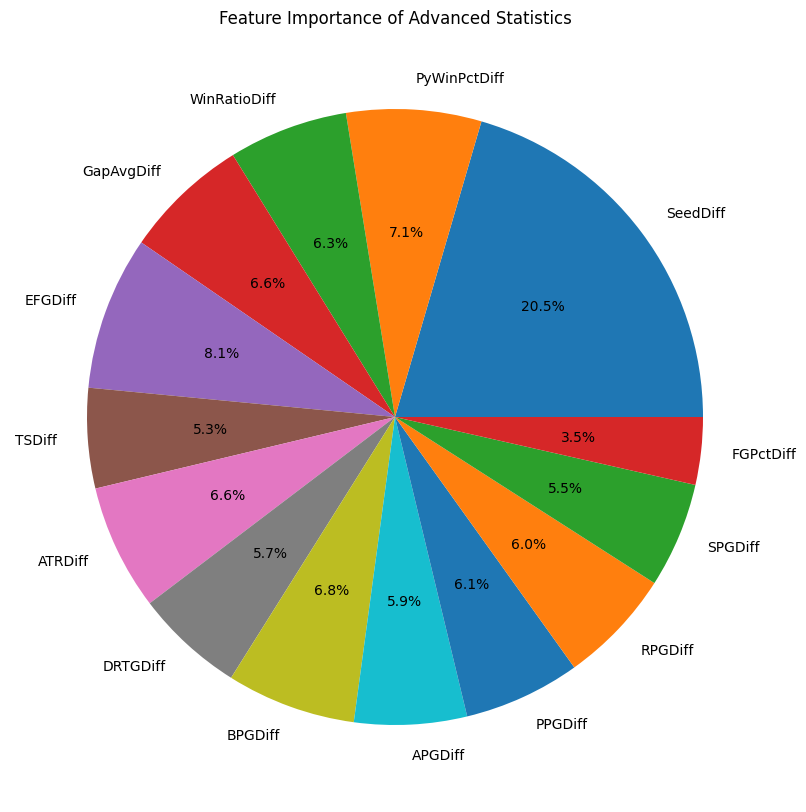

In [1027]:
# pie chart of feature importance
plt.figure(figsize=(10, 10))
plt.pie(model.feature_importances_, labels=X.columns, autopct="%1.1f%%")
plt.title("Feature Importance of Advanced Statistics")
plt.show()